This analysis investigates the effect Daylight Saving Time (DST) has on the american population's sunrise and sunset times. The purpose of doing this is to support my position in arguments with my friends that DST should be extended year round. 

To understand the effect of DST on the distribution of sunrise and sunset times in the United States, I estimate what time the sun rises and sets every day for each person in the country. The time differs from person to person due to changes in geographical location (eg the on 7/10/2021 the sunrises at ). We define geographical location at the level of census block. There are over 11 million census blocks and 365 days in the year, which equates to over 4 billion unique sunrise and sunset times. The primary challenge of this project, beyond identifying and joining relevant data sources, is calculating these 4+ billion sunrise/sunset times in a time-efficient manner. 

The steps are the following:
1. Download shape file and population data for each census block
2. Calculate centroid (latitude / longitude) for each census block
3. Get timezone associated with each census block
4. Calculate sunrise / sunset time for each day for each census block based on centroid
5. Create plot of sunrise/sunset distributions with and without DST

In [183]:
import pandas as pd
import geopandas as gpd
import os
import requests
import pickle
import importlib
import datetime
import time
import requests

# local imports
import vectorized_suncalc

# 1. Download shape file and population data for each census block

In [ ]:
save_path = r"data\2010 TIGER Shape and Demographic Files"

for i in range(60):
    print(f"i = {i}")
    url = f'https://www2.census.gov/geo/tiger/TIGER2010BLKPOPHU/tabblock2010_{i:02}_pophu.zip'
    save_to = os.path.join(save_path, f'tabblock2010_{i:03}_pophu.zip')
    r = requests.get(url, allow_redirects=True)
    if r.status_code == 404:
        print("Index f{i:02} resulted in status code 404")
        continue
    else:
        with open(save_to, 'wb') as f:
            f.write(r.content)

# 2. Calculate centroid (lat/lon) for each census block


In [1]:
save_path = r"data\2010 TIGER Shape and Demographic Files"
inp = input("Continue? (y/n): ")
if inp=="y":
    df = None
    for d in os.listdir(save_path):
        if d[-4:]==".shp":
            print(f'Adding in {d}')
            poly = gpd.read_file(os.path.join(save_path,d))
            poly['lon'] = poly['geometry'].centroid.x
            poly['lat'] = poly['geometry'].centroid.y
            df_i = pd.DataFrame(poly.drop(columns=['geometry']))

            if df is None: 
                df = df_i
            else:   
                df = pd.concat([df,df_i], axis=0, ignore_index=True)
    df.to_pickle("data/all_block_data_2.pkl")

Continue? (y/n): n


In [3]:
with open("data/all_block_data_2.pkl", 'rb') as f:
    df = pickle.load(f)
df.head(1)

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE,BLOCKID10,PARTFLG,HOUSING10,POP10,lon,lat,state_county
0,01,001,020500,1028,010010205001028,N,0,0,-86.411659,32.426078,01001


In [4]:
# Filter out blocks with no inhabitants
df = df[df['POP10']>0]

# 3. Get timezone (TZ) associated with each census block

#### - 3a. Find TZ associated with each state, for states which have a single time zone

In [28]:
def fetch_tz_from_coord(lat,lon):
    url = f"http://api.geonames.org/timezoneJSON?formatted=true&lat={lat}&lng={lon}&username=ryan&style=full"
    r = requests.get(url) 
    return r.json()['timezoneId']

In [29]:
multi_timezone_states = ['Oregon','Idaho','Nebraska','Kansas','Texas','North Dakota','South Dakota','Florida','Michigan',
                         'Indiana','Kentucky','Tennessee','Alaska']

In [30]:
state_codes = pd.read_csv('data/FIPS State Numeric Code Table.csv', header=None)
state_codes.columns=['name','code','abrev']
state_code_dict = dict(state_codes.set_index('name')['code'])
code_state_dict = dict(state_codes.set_index('code')['name'])

In [31]:
multi_timezone_codes = [state_code_dict[state] for state in multi_timezone_states]

In [32]:
inp = input("Continue? (y/n): ")
if inp=="y":
    code_timezone_dict = dict.fromkeys(code_state_dict.keys())
    for key in code_timezone_dict.keys():
        if key in multi_timezone_codes:
            continue
        else:
            state_code = f'{key:02}'
            state_sample = df[df['STATEFP10']==state_code].sample(10)
            lon = state_sample['lon'].mean()
            lat = state_sample['lat'].mean()
            tz = fetch_tz_from_coord(lat,lon)
            code_timezone_dict[key] = tz
    with open('data/certain_state_to_timezone_dict.pkl', 'wb') as f:
        pickle.dump(code_timezone_dict_2, f)

In [5]:
with open('data/certain_state_to_timezone_dict.pkl', 'rb') as f:
    code_timezone_dict = pickle.load(f)

#### - 3a. Find TZ associated with each county, for counties in states which multiple time zones

In [44]:
df['state_county'] = df['STATEFP10']+df['COUNTYFP10']

In [47]:
df_county = df.drop_duplicates(subset='state_county')

In [85]:
uncertain_state_codes = [key for key in code_timezone_dict if code_timezone_dict[key] is None]

In [107]:
n=0
inp = input("Continue? (y/n): ")
if inp=="y":
    for state in uncertain_state_codes:
        state_code = f'{state:02}'
        df_county_i = df_county[df_county['STATEFP10']==state_code]
        # For each county in state
        for i, row in df_county_i.iterrows():
            county_id = row['COUNTYFP10']
            # check if county already added...
            if row['state_county'] in code_timezone_dict_2:
                #print(f"{row['state_county']} already exists in code_timezone_dict!")
                pass
            else:
                lat = row['lat']
                lon = row['lon']
                tz = fetch_tz_from_coord(lat,lon)
                code_timezone_dict_2[row['state_county']] = tz
            n+=1
            if n%100 == 0:
                print(f'Done with {n}')
    with open('data/state_county_to_timezone_dict.pkl', 'wb') as f:
    pickle.dump(code_timezone_dict_2, f)

Done with 100
Done with 200
Done with 300
Done with 400
Done with 500
Done with 600
Done with 700
Done with 800
Done with 900
Done with 1000
Done with 1100


In [6]:
with open('data/state_county_to_timezone_dict.pkl', 'rb') as f:
    code_timezone_dict_2 = pickle.load(f)

Add time-zone info to df

In [7]:
# time-zone by state
df['tz'] = df['STATEFP10'].apply(lambda x: code_timezone_dict[int(x)])

In [8]:
# time-zone by county
def get_timezone(row):
    tz = row['tz']
    if tz is None:
        return code_timezone_dict_2[x['state_county']]
    else:
        return tz

df['tz'] = df.apply(get_timezone, axis=1)

# 4. Calculate sunrise / sunset times for each day for each census block based on centroid

### 4a. Sunrise calculation

In [201]:
dt_i = pytz.utc.localize(datetime.datetime(year=2010, month=1, day=1))
bins = np.arange(0, 24*60, 1)
sum_counts, _ = np.histogram([], bins=bins)
sum_counts_no_dst, _ = np.histogram([], bins=bins)
sum_counts_all_dst, _ = np.histogram([], bins=bins)

counts_list = []
counts_all_dst_list = []
counts_no_dst_list = []

t0 = time.time()
while dt_i.year==2010:
    print(f'{dt_i}, and {(time.time()-t0)/60} minutes in')
    lon = df['lon'].to_numpy()
    lat = df['lat'].to_numpy()
    df['sunrise_utc'] = vectorized_suncalc.get_sunrise_vec(lat,lon,dt_i)
    
    invalid_cutoff = dt_i-datetime.timedelta(days=90)
    df_valid = df.loc[df['sunrise_utc']>invalid_cutoff]
        
    for tz in df_valid['tz'].unique():
        tz_bool = df_valid['tz'] == tz
        df_tz = df_valid[tz_bool]
        local_time = utc_to_local(df_tz['sunrise_utc'], tz)
        
        dst_offset = local_time.sample().iloc[0].dst()
        if dst_offset.seconds > 0:
            local_time_all_dst = local_time
            local_time_no_dst = local_time - dst_offset
        else:
            local_time_all_dst = local_time + datetime.timedelta(seconds=3600)
            local_time_no_dst = local_time
        
        local_min = local_time_to_min(local_time)
        local_min_no_dst = local_time_to_min(local_time_no_dst)
        local_min_all_dst = local_time_to_min(local_time_all_dst)
        
        counts, _ = np.histogram(local_min, bins=bins)
        counts_no_dst, _ = np.histogram(local_min_no_dst, bins=bins)
        counts_all_dst, _ = np.histogram(local_min_all_dst, bins=bins)
        
        sum_counts = sum_counts + counts
        sum_counts_no_dst = sum_counts_no_dst + counts_no_dst
        sum_counts_all_dst = sum_counts_all_dst + counts_all_dst
        
        counts_list.append(counts)
        counts_no_dst_list.append(counts_no_dst)
        counts_all_dst_list.append(counts_all_dst)
        
    dt_i = dt_i + datetime.timedelta(days=1)

2010-01-01 00:00:00+00:00  and  0.0  minutes in
2010-01-02 00:00:00+00:00  and  0.9012767950693766  minutes in
2010-01-03 00:00:00+00:00  and  1.8098193526268005  minutes in
2010-01-04 00:00:00+00:00  and  2.757051686445872  minutes in
2010-01-05 00:00:00+00:00  and  3.665884490807851  minutes in
2010-01-06 00:00:00+00:00  and  4.589490191141764  minutes in
2010-01-07 00:00:00+00:00  and  5.57680223385493  minutes in
2010-01-08 00:00:00+00:00  and  6.464082682132721  minutes in
2010-01-09 00:00:00+00:00  and  7.343773293495178  minutes in
2010-01-10 00:00:00+00:00  and  8.242436961332958  minutes in
2010-01-11 00:00:00+00:00  and  9.134606870015462  minutes in
2010-01-12 00:00:00+00:00  and  10.0137469291687  minutes in
2010-01-13 00:00:00+00:00  and  10.890794372558593  minutes in
2010-01-14 00:00:00+00:00  and  11.747749098141988  minutes in
2010-01-15 00:00:00+00:00  and  12.637877825895945  minutes in
2010-01-16 00:00:00+00:00  and  13.507081091403961  minutes in
2010-01-17 00:00:0

2010-05-13 00:00:00+00:00  and  122.00428207317988  minutes in
2010-05-14 00:00:00+00:00  and  122.9461150487264  minutes in
2010-05-15 00:00:00+00:00  and  123.88690959215164  minutes in
2010-05-16 00:00:00+00:00  and  124.7914042711258  minutes in
2010-05-17 00:00:00+00:00  and  125.71033516724904  minutes in
2010-05-18 00:00:00+00:00  and  126.63891377449036  minutes in
2010-05-19 00:00:00+00:00  and  127.55589133103689  minutes in
2010-05-20 00:00:00+00:00  and  128.49457232554752  minutes in
2010-05-21 00:00:00+00:00  and  129.41041487058004  minutes in
2010-05-22 00:00:00+00:00  and  130.31597009102504  minutes in
2010-05-23 00:00:00+00:00  and  131.2090805808703  minutes in
2010-05-24 00:00:00+00:00  and  132.12242262363435  minutes in
2010-05-25 00:00:00+00:00  and  133.0281097173691  minutes in
2010-05-26 00:00:00+00:00  and  133.9821275472641  minutes in
2010-05-27 00:00:00+00:00  and  134.9011813521385  minutes in
2010-05-28 00:00:00+00:00  and  135.81199822028478  minutes i

2010-09-21 00:00:00+00:00  and  242.2608326236407  minutes in
2010-09-22 00:00:00+00:00  and  243.38655150731404  minutes in
2010-09-23 00:00:00+00:00  and  244.33947099844616  minutes in
2010-09-24 00:00:00+00:00  and  245.27580053806304  minutes in
2010-09-25 00:00:00+00:00  and  246.18963411251704  minutes in
2010-09-26 00:00:00+00:00  and  247.09473127126694  minutes in
2010-09-27 00:00:00+00:00  and  248.04180736939114  minutes in
2010-09-28 00:00:00+00:00  and  248.93942410151163  minutes in
2010-09-29 00:00:00+00:00  and  249.8386268377304  minutes in
2010-09-30 00:00:00+00:00  and  250.75792107184728  minutes in
2010-10-01 00:00:00+00:00  and  251.6697834690412  minutes in
2010-10-02 00:00:00+00:00  and  252.570493833224  minutes in
2010-10-03 00:00:00+00:00  and  253.48737173875173  minutes in
2010-10-04 00:00:00+00:00  and  254.37703823248546  minutes in
2010-10-05 00:00:00+00:00  and  255.2947885632515  minutes in
2010-10-06 00:00:00+00:00  and  256.2097356796265  minutes in

In [ ]:
with open('data/sum_counts_no_dst.pkl','wb') as f:
    pickle.dump(sum_counts_no_dst, f)
    
with open('data/sum_counts_all_dst.pkl','wb') as f:
    pickle.dump(sum_counts_all_dst, f)
    
with open('data/sum_counts.pkl','wb') as f:
    pickle.dump(sum_counts, f)
    
with open('data/counts_no_dst_list.pkl','wb') as f:
    pickle.dump(counts_no_dst_list, f)
    
with open('data/counts_all_dst_list.pkl','wb') as f:
    pickle.dump(counts_all_dst_list, f)
    
with open('data/counts_list.pkl','wb') as f:
    pickle.dump(counts_list, f)

### 4b. Sunset calculation

In [327]:
dt_i = pytz.utc.localize(datetime.datetime(year=2010, month=1, day=1))
bins = np.arange(0, 24*60, 1)
set_sum_counts, _ = np.histogram([], bins=bins)
set_sum_counts_no_dst, _ = np.histogram([], bins=bins)
set_sum_counts_all_dst, _ = np.histogram([], bins=bins)

set_counts_list = []
set_counts_all_dst_list = []
set_counts_no_dst_list = []

t0 = time.time()
while dt_i.year==2010:
    print(dt_i,' and ', (time.time()-t0)/60, ' minutes in')
    lon = df['lon'].to_numpy()
    lat = df['lat'].to_numpy()
    df['sunrise_utc'] = vectorized_suncalc.get_sunset_vec(lat,lon,dt_i)
    
    invalid_cutoff = dt_i-datetime.timedelta(days=90)
    df_valid = df.loc[df['sunrise_utc']>invalid_cutoff]
    
    for tz in df_valid['tz'].unique():
        tz_bool = df_valid['tz'] == tz
        df_tz = df_valid[tz_bool]
        local_time = utc_to_local(df_tz['sunrise_utc'], tz)
        
        dst_offset = local_time.sample().iloc[0].dst()
        if dst_offset.seconds > 0:
            local_time_all_dst = local_time
            local_time_no_dst = local_time - dst_offset
        else:
            local_time_all_dst = local_time + datetime.timedelta(seconds=3600)
            local_time_no_dst = local_time
        
        local_min = local_time_to_min(local_time)
        local_min_no_dst = local_time_to_min(local_time_no_dst)
        local_min_all_dst = local_time_to_min(local_time_all_dst)

        
        set_counts, _ = np.histogram(local_min, bins=bins)
        set_counts_no_dst, _ = np.histogram(local_min_no_dst, bins=bins)
        set_counts_all_dst, _ = np.histogram(local_min_all_dst, bins=bins)
        
        set_sum_counts = set_sum_counts + set_counts
        set_sum_counts_no_dst = set_sum_counts_no_dst + set_counts_no_dst
        set_sum_counts_all_dst = set_sum_counts_all_dst + set_counts_all_dst
        
        set_counts_list.append(set_counts)
        set_counts_no_dst_list.append(set_counts_no_dst)
        set_counts_all_dst_list.append(set_counts_all_dst)

    dt_i = dt_i + datetime.timedelta(days=1)

2010-01-01 00:00:00+00:00  and  0.0  minutes in


C:\Users\volpir\Documents\Notebooks\For Fun\dst_analysis\suncalc.py:243: RuntimeWarning: invalid value encountered in arccos
  # import time
C:\Users\volpir\Documents\Notebooks\For Fun\dst_analysis\suncalc.py:138: RuntimeWarning: invalid value encountered in arcsin
  


2010-01-02 00:00:00+00:00  and  1.042784078915914  minutes in
2010-01-03 00:00:00+00:00  and  1.979592764377594  minutes in
2010-01-04 00:00:00+00:00  and  2.9042262196540833  minutes in
2010-01-05 00:00:00+00:00  and  3.831922260920207  minutes in
2010-01-06 00:00:00+00:00  and  4.77773224512736  minutes in
2010-01-07 00:00:00+00:00  and  5.699843072891236  minutes in
2010-01-08 00:00:00+00:00  and  6.642824641863505  minutes in
2010-01-09 00:00:00+00:00  and  7.585805181662241  minutes in
2010-01-10 00:00:00+00:00  and  8.512916274865468  minutes in
2010-01-11 00:00:00+00:00  and  9.450480445226033  minutes in
2010-01-12 00:00:00+00:00  and  10.38129365046819  minutes in
2010-01-13 00:00:00+00:00  and  11.286774301528931  minutes in
2010-01-14 00:00:00+00:00  and  12.237963859240214  minutes in
2010-01-15 00:00:00+00:00  and  13.15569152434667  minutes in
2010-01-16 00:00:00+00:00  and  14.118072895208995  minutes in
2010-01-17 00:00:00+00:00  and  15.05960417985916  minutes in
2010-

2010-05-14 00:00:00+00:00  and  125.76997010707855  minutes in
2010-05-15 00:00:00+00:00  and  126.70856103102366  minutes in
2010-05-16 00:00:00+00:00  and  127.63599218130112  minutes in
2010-05-17 00:00:00+00:00  and  128.5653176546097  minutes in
2010-05-18 00:00:00+00:00  and  129.50424723227817  minutes in
2010-05-19 00:00:00+00:00  and  130.4696393052737  minutes in
2010-05-20 00:00:00+00:00  and  131.4047737121582  minutes in
2010-05-21 00:00:00+00:00  and  132.36848297516505  minutes in
2010-05-22 00:00:00+00:00  and  133.30310334761938  minutes in
2010-05-23 00:00:00+00:00  and  134.27564338445663  minutes in
2010-05-24 00:00:00+00:00  and  135.20966608126957  minutes in
2010-05-25 00:00:00+00:00  and  136.156765405337  minutes in
2010-05-26 00:00:00+00:00  and  137.09934775829316  minutes in
2010-05-27 00:00:00+00:00  and  138.04399793545406  minutes in
2010-05-28 00:00:00+00:00  and  138.98713853359223  minutes in
2010-05-29 00:00:00+00:00  and  139.94345314502715  minutes 

2010-09-22 00:00:00+00:00  and  251.62289849917093  minutes in
2010-09-23 00:00:00+00:00  and  252.6407726486524  minutes in
2010-09-24 00:00:00+00:00  and  253.72391205628713  minutes in
2010-09-25 00:00:00+00:00  and  254.71993676424026  minutes in
2010-09-26 00:00:00+00:00  and  255.65577180385588  minutes in
2010-09-27 00:00:00+00:00  and  256.6141637047132  minutes in
2010-09-28 00:00:00+00:00  and  257.5901371717453  minutes in
2010-09-29 00:00:00+00:00  and  258.5506648580233  minutes in
2010-09-30 00:00:00+00:00  and  259.52432033618294  minutes in
2010-10-01 00:00:00+00:00  and  260.47398385206856  minutes in
2010-10-02 00:00:00+00:00  and  261.4434157292048  minutes in
2010-10-03 00:00:00+00:00  and  262.39359207948047  minutes in
2010-10-04 00:00:00+00:00  and  263.37242896954217  minutes in
2010-10-05 00:00:00+00:00  and  264.3744508544604  minutes in
2010-10-06 00:00:00+00:00  and  265.5703375776609  minutes in
2010-10-07 00:00:00+00:00  and  266.5508375724157  minutes in


In [ ]:
with open('data/set_sum_counts_no_dst.pkl','wb') as f:
    pickle.dump(set_sum_counts_no_dst, f)
    
with open('data/set_sum_counts_all_dst.pkl','wb') as f:
    pickle.dump(set_sum_counts_all_dst, f)
    
with open('data/set_sum_counts.pkl','wb') as f:
    pickle.dump(set_sum_counts, f)
    
with open('data/set_counts_no_dst_list.pkl','wb') as f:
    pickle.dump(set_counts_no_dst_list, f)
    
with open('data/set_counts_all_dst_list.pkl','wb') as f:
    pickle.dump(set_counts_all_dst_list, f)
    
with open('data/set_counts_list.pkl','wb') as f:
    pickle.dump(set_counts_list, f)

# 5. Create plot of sunrise/sunset distributions with and without DST

In [257]:
def group_every_n(bins, counts, n):
    bins_group = []
    counts_group = []
    count_group = 0
    for b, c in zip(bins[:-1], counts):
        count_group += c
        if b%n == 0:
            bins_group.append(b)
            counts_group.append(count_group)
            count_group = 0
    return bins_group, counts_group

In [376]:
def hour_to_text(hours):
    labs = []
    for hour in hours:
        h = int(hour)
        m = int((hour-h)*60)
        labs.append(f"{h%12}:{m:02}")
    return labs

In [543]:
def plot_hist(ax, bins, counts, min_h, max_h, sum_every=10):
    bins_group, counts_group = group_every_n(bins, counts, sum_every)
    hours = [b/60 for b in bins_group]
    hour_marks = np.arange(min_h, max_h+1, 1)
    hour_labels = hour_to_text(hour_marks)
    ax.bar(
        bins_group, 
        counts_group, 
        width=sum_every, 
        align='edge', 
        color='#404141', 
        edgecolor='k', 
        snap=True,
        linewidth=0
    )
    ax.set_xlim(min_h*60,max_h*60);
    ax.set_xticks(np.array(hour_marks)*60);
    ax.set_xticklabels(hour_labels, fontsize=14)
    ax.set_yticks([],[])
    ax.grid(axis='x',linestyle='dashed', linewidth=1)
    return ax

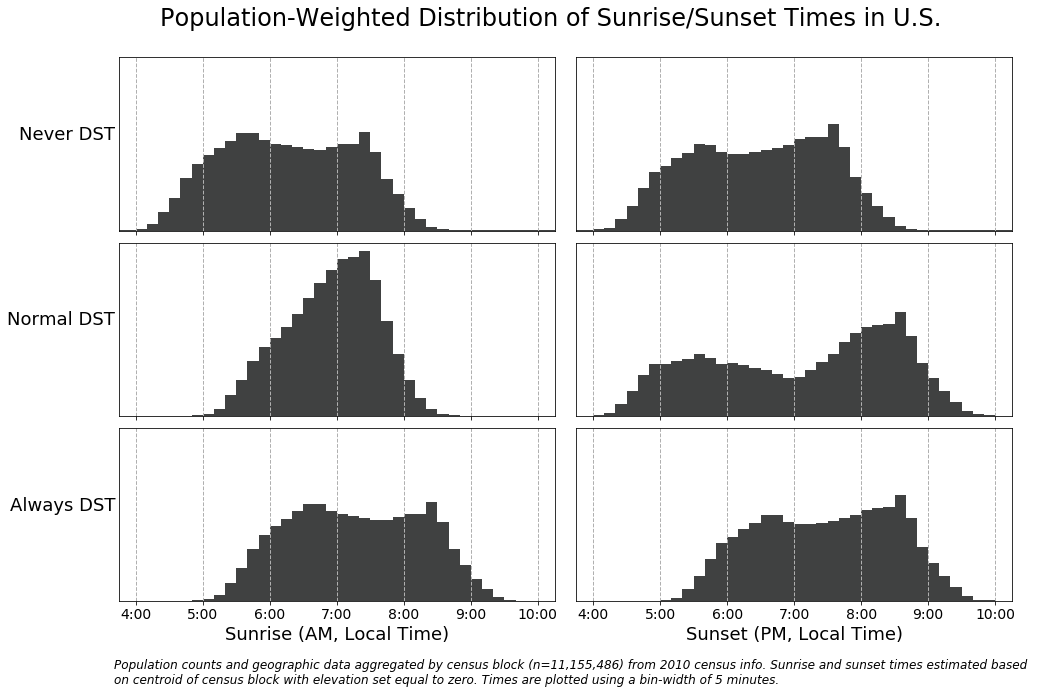

In [544]:
fig, axs = plt.subplots(3, 2, figsize=(16,10), sharex='col', sharey=True, gridspec_kw={'wspace':0.05, 'hspace':0.07})

min_h = 3
max_h = 10

axs[0,0] = plot_hist(axs[0,0], bins, sum_counts_no_dst, min_h, max_h)
axs[1,0] = plot_hist(axs[1,0], bins, sum_counts, min_h, max_h)
axs[2,0] = plot_hist(axs[2,0], bins, sum_counts_all_dst, min_h, max_h)

min_h = 15
max_h = 22
axs[0,1] = plot_hist(axs[0,1], bins, set_sum_counts_no_dst, min_h, max_h)
axs[1,1] = plot_hist(axs[1,1], bins, set_sum_counts, min_h, max_h)
axs[2,1] = plot_hist(axs[2,1], bins, set_sum_counts_all_dst, min_h, max_h)

axs[0,0].set_ylabel("Never DST", fontsize=18, rotation=0, ha='right')
axs[1,0].set_ylabel("Normal DST", fontsize=18, rotation=0, ha='right')
axs[2,0].set_ylabel("Always DST", fontsize=18, rotation=0, ha='right')

axs[2,0].set_xlabel("Sunrise (AM, Local Time)", fontsize=18)
axs[2,1].set_xlabel("Sunset (PM, Local Time)", fontsize=18)

axs[2,1].set_xlim(15.75*60, 22.25*60)
axs[2,0].set_xlim(3.75*60, 10.25*60)

plt.suptitle("Population-Weighted Distribution of Sunrise/Sunset Times in U.S.", fontsize=24,y=0.95)
plt.savefig('DST Graph v2.jpg')

plt.figtext(0.121, 0.01, 
            "Population counts and geographic data aggregated by census block (n=11,155,486) from 2010 census info. Sunrise and sunset times estimated based \n"
            +"on centroid of census block with elevation set equal to zero. Times are plotted using a bin-width of 5 minutes.", fontsize=12,style='italic')

plt.show()